In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import jax.numpy as np
import numpy as onp
import time
from tqdm import tqdm
from led_array.bsccm_utils import *
from image_utils import *

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')
bsccm_coherent = BSCCM('/home/hpinkard_waller/data/BSCCM-coherent/')

Opening BSCCM
Opened BSCCM
Opening BSCCM-coherent
Opened BSCCM-coherent


In [4]:
num_images = 1000
patch_size = 50
num_patches = 2000

channels = ['LED119', 'DF_50', 'DPC_Right', 'Brightfield']
cov_mats = {}
example_patches = {}

for channel in channels:
    images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=32, convert_units_to_photons=True)  
    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)
    example_patches[channel] = patches[0]
    mat = compute_cov_mat(patches)
    cov_mats[channel] = mat
# normalize all cov mats into correlation matrices
corr_mats = {}
for channel, mat in cov_mats.items():
    corr_mats[channel] = mat / np.sqrt(np.diag(mat)[:, None] * np.diag(mat)[None, :])


100%|██████████| 2000/2000 [00:00<00:00, 958041.11it/s]


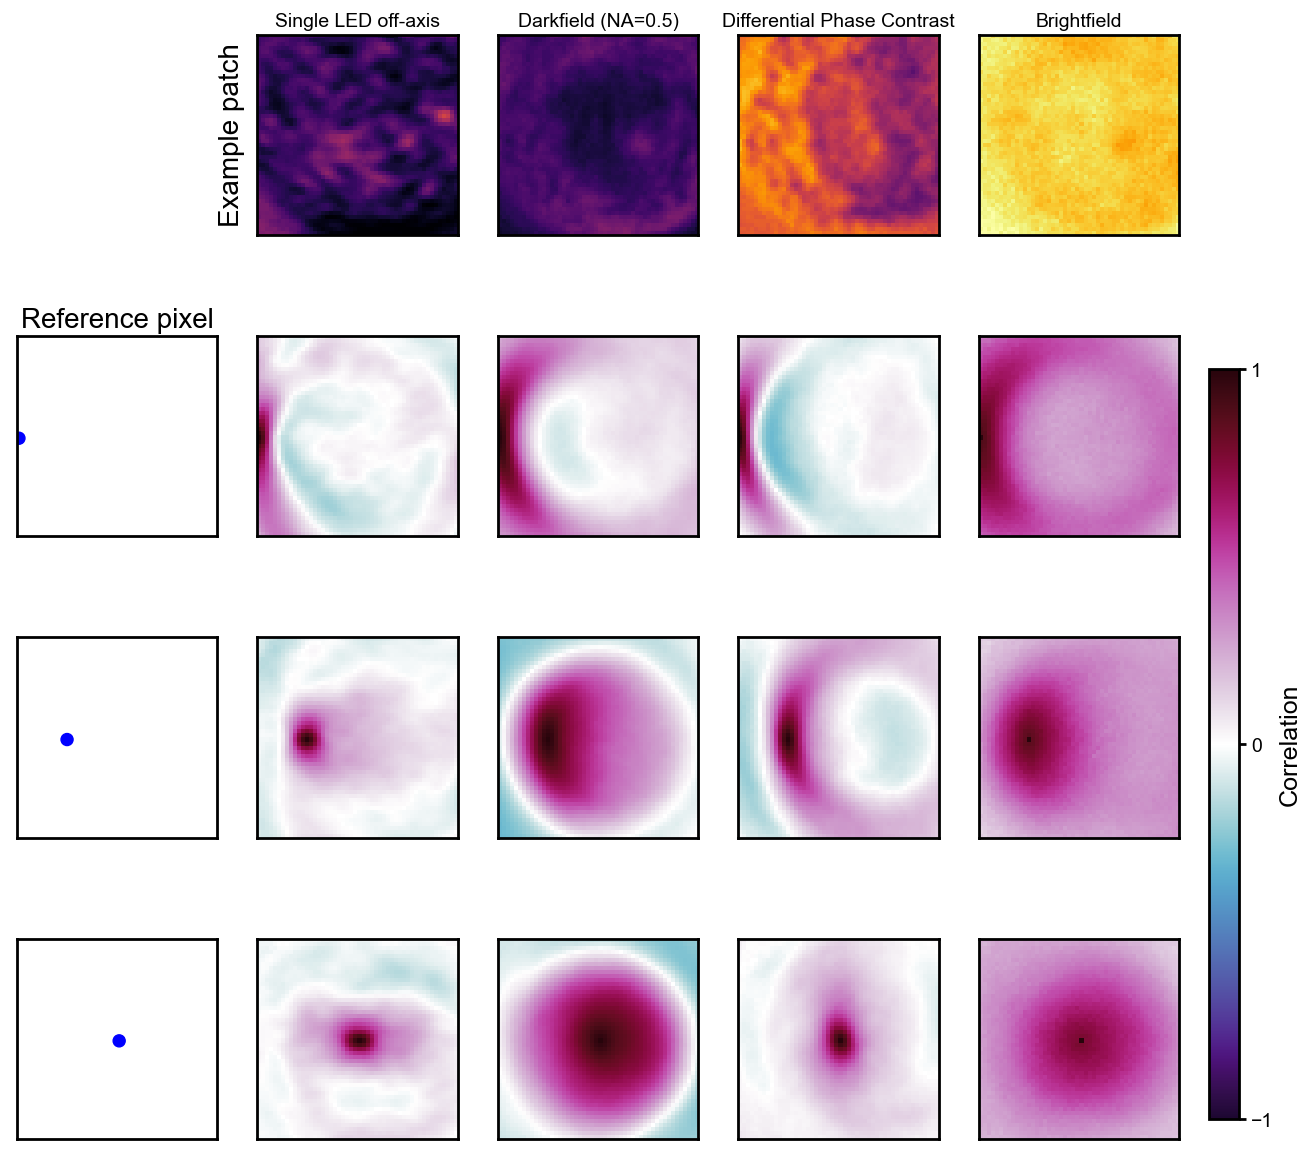

In [6]:
import cmasher as cmr

cols = [0, 12, 25]

use_correlation = True

# plot all 4 next to eachother
fig, axes = plt.subplots(len(cols) + 1, len(channels) + 1, figsize=(15, 15))
axes[0, 0].axis('off')


# first row, example patches
all_pix = np.concatenate([example_patches[channel].flatten() for channel in channels])
contrast_limits = [np.percentile(all_pix, .1), np.percentile(all_pix, 99.9)]
mats = corr_mats if use_correlation else cov_mats
for channel, mat in mats.items():
    axes[0, channels.index(channel) + 1].imshow(example_patches[channel], cmap='inferno', 
                                                vmin=contrast_limits[0], vmax=contrast_limits[1], interpolation='nearest')
    axes[0, channels.index(channel) + 1].set(xticks=[], yticks=[], title=get_display_channel_names(channel))

axes[0,1].set_ylabel('Example patch', fontsize=20)

for row_index, col in enumerate(cols):
    row = patch_size // 2
    # col = patch_size // 2
    index = row * patch_size + col


    if use_correlation:
        all_vals = np.concatenate([corr_mats[channel][index, :] for channel in channels])
        max_deviation = 1
        mats = corr_mats
    else:
        all_vals = np.concatenate([cov_mats[channel][index, :] for channel in channels])
        max_deviation = np.max(np.abs(all_vals))
        mats = cov_mats

    

    # In the first column, plot a mpl patch circle that marks the pixel we're looking at
    axes[row_index + 1, 0].imshow(np.ones((patch_size, patch_size)), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    axes[row_index + 1, 0].add_patch(plt.Circle(np.array((col, row)), radius=1.5, color='blue', fill=True))
    # axes[row_index + 1, 0].set_aspect('equal')
    axes[row_index + 1, 0].set(xticks=[], yticks=[])

    for channel, mat in mats.items():
        image = mat[index, :].reshape(patch_size, patch_size)
        axes[row_index + 1, channels.index(channel) + 1].imshow(image, cmap=cmr.viola, 
                            vmin=-max_deviation, vmax=max_deviation, interpolation='nearest')
        axes[row_index + 1, channels.index(channel) + 1].set(xticks=[], yticks=[])


axes[1, 0].set_title('Reference pixel', fontsize=20)

# add another set of axes to draw a vertical colorbar on the top right
cax = fig.add_axes([0.92, 0.14, 0.02, 0.5])
cbar = fig.colorbar(axes[1, 1].images[0], cax=cax)
if use_correlation:
    cbar.set_ticks([-1, 0, 1])
else:
    cbar.set_ticks([-max_deviation, 0, max_deviation])

cbar.set_label('Correlation' if use_correlation else 'Covariance')




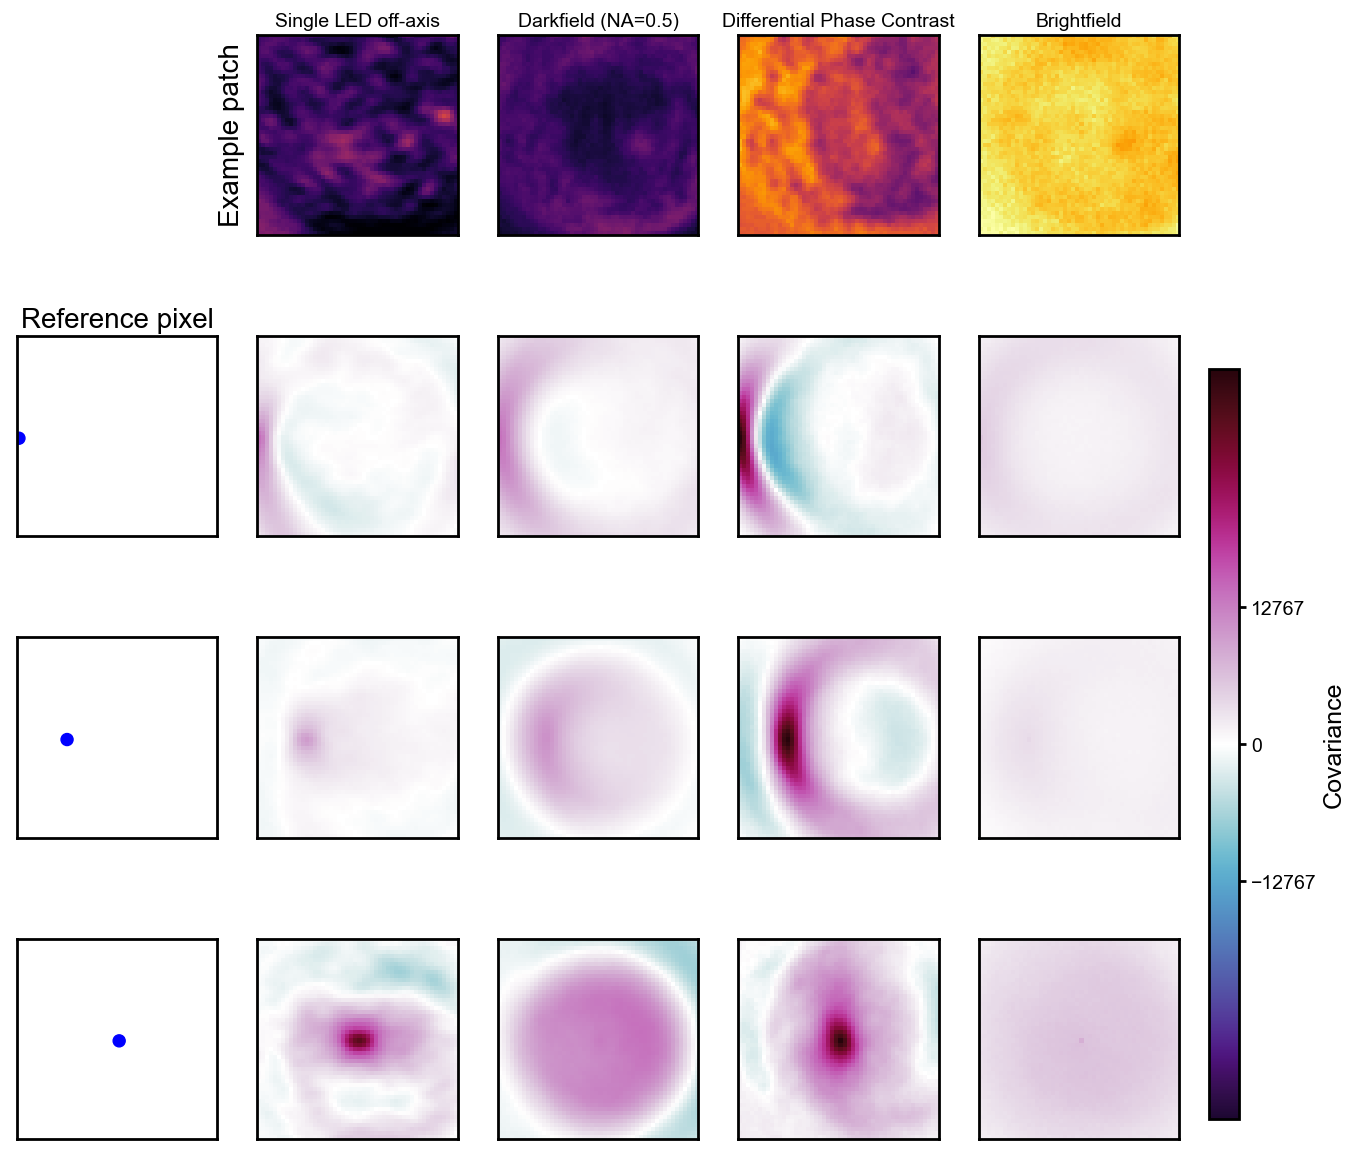

: 

In [7]:
import cmasher as cmr

cols = [0, 12, 25]

use_correlation = False

# plot all 4 next to eachother
fig, axes = plt.subplots(len(cols) + 1, len(channels) + 1, figsize=(15, 15))
axes[0, 0].axis('off')


# first row, example patches
all_pix = np.concatenate([example_patches[channel].flatten() for channel in channels])
contrast_limits = [np.percentile(all_pix, .1), np.percentile(all_pix, 99.9)]
for channel, mat in mats.items():
    axes[0, channels.index(channel) + 1].imshow(example_patches[channel], cmap='inferno', 
                                                vmin=contrast_limits[0], vmax=contrast_limits[1], interpolation='nearest')
    axes[0, channels.index(channel) + 1].set(xticks=[], yticks=[], title=get_display_channel_names(channel))

axes[0,1].set_ylabel('Example patch', fontsize=20)

for row_index, col in enumerate(cols):
    row = patch_size // 2
    # col = patch_size // 2
    index = row * patch_size + col


    if use_correlation:
        all_vals = np.concatenate([corr_mats[channel][index, :] for channel in channels])
        max_deviation = 1
        mats = corr_mats
    else:
        all_vals = np.concatenate([cov_mats[channel][index, :] for channel in channels])
        max_deviation = np.max(np.abs(all_vals))
        mats = cov_mats

    

    # In the first column, plot a mpl patch circle that marks the pixel we're looking at
    axes[row_index + 1, 0].imshow(np.ones((patch_size, patch_size)), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    axes[row_index + 1, 0].add_patch(plt.Circle(np.array((col, row)), radius=1.5, color='blue', fill=True))
    # axes[row_index + 1, 0].set_aspect('equal')
    axes[row_index + 1, 0].set(xticks=[], yticks=[])

    for channel, mat in mats.items():
        image = mat[index, :].reshape(patch_size, patch_size)
        axes[row_index + 1, channels.index(channel) + 1].imshow(image, cmap=cmr.viola, 
                            vmin=-max_deviation, vmax=max_deviation, interpolation='nearest')
        axes[row_index + 1, channels.index(channel) + 1].set(xticks=[], yticks=[])


axes[1, 0].set_title('Reference pixel', fontsize=20)

# add another set of axes to draw a vertical colorbar on the top right
cax = fig.add_axes([0.92, 0.14, 0.02, 0.5])
cbar = fig.colorbar(axes[1, 1].images[0], cax=cax)
if use_correlation:
    cbar.set_ticks([-1, 0, 1])
else:
    cbar.set_ticks([-max_deviation, 0, max_deviation])

cbar.set_label('Correlation' if use_correlation else 'Covariance')
